In [1]:
# Importing required libraries
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from mlxtend.frequent_patterns import apriori, association_rules
import time
import gc
gc.collect()

0

In [2]:
# Adjusting some desplay options
pd.set_option('mode.chained_assignment',None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 500)
pd.options.display.float_format= '{:.2f}'.format

In [3]:
# Specify dataset directory path
dataset_directory = 'C:\\Users\\Ahmed\\Desktop\\ecommerce\\'

In [4]:
# Reading and optimizing data
start = time.time()
item_properties_part1= pd.read_csv(dataset_directory+'item_properties_part1.csv')
item_properties_part2= pd.read_csv(dataset_directory+'item_properties_part2.csv')
# Merging item_properties files
item_properties= pd.concat([item_properties_part1, item_properties_part2])
# adjusting timestamp format to datetime
item_properties['timestamp']= pd.to_datetime(item_properties['timestamp'],unit='ms')
# Enhancing memory usage
item_properties['itemid']= pd.to_numeric(item_properties['itemid'], downcast='unsigned')


category_tree= pd.read_csv(dataset_directory+'category_tree.csv')
category_tree['categoryid']= pd.to_numeric(category_tree['categoryid'], downcast='unsigned')
# Handeling null parentid by 0 >> 0 means categories without parent
category_tree['parentid']= category_tree['parentid'].fillna(0)
category_tree['parentid']= pd.to_numeric(category_tree['parentid'], downcast='unsigned')


events= pd.read_csv(dataset_directory+'events.csv')
events['timestamp']= pd.to_datetime(events['timestamp'],unit='ms')
events['itemid']= pd.to_numeric(events['itemid'], downcast='unsigned')
events['visitorid']= pd.to_numeric(events['visitorid'], downcast='unsigned')

end = time.time()
print(end - start)

15.232887029647827


In [5]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   categoryid  1669 non-null   uint16
 1   parentid    1669 non-null   uint16
dtypes: uint16(2)
memory usage: 6.6 KB


In [6]:
# Exploring category tree
category_tree.groupby("parentid")\
.agg(value_count=('categoryid', 'count'),
     distinct_values=('categoryid', 'unique'))\
.sort_values('value_count', ascending=False).reset_index().head(10)

,parentid,value_count,distinct_values
0,250,31,"[7, 1252, 463, 543, 457, 678, 1485, 1086, 1669, 1695, 420, 238, 546, 642, 74, 1120, 1613, 391, 795, 1561, 1027, 583, 506, 1420, 724, 1629, 1335, 1167, 1402, 329, 1190]"
1,0,25,"[231, 791, 1490, 431, 755, 378, 1579, 1394, 659, 1057, 859, 803, 250, 1452, 1182, 1692, 1600, 1482, 1224, 1532, 395, 653, 140, 1698, 679]"
2,1009,22,"[534, 1358, 198, 501, 1556, 481, 1510, 354, 1522, 264, 1287, 184, 284, 728, 976, 1488, 447, 923, 1489, 30, 1644, 1310]"
3,362,22,"[741, 508, 512, 1432, 1069, 1577, 598, 492, 952, 350, 111, 518, 278, 674, 221, 1342, 1304, 273, 1419, 271, 301, 246]"
4,351,19,"[102, 21, 1570, 1633, 119, 1562, 1447, 1124, 1270, 1026, 199, 9, 1239, 1499, 946, 405, 161, 1063, 639]"
5,1259,18,"[1427, 1061, 389, 166, 996, 1271, 472, 1408, 882, 1210, 311, 179, 1245, 1552, 150, 991, 1285, 823]"
6,1687,17,"[108, 1512, 32, 294, 68, 443, 906, 922, 79, 1044, 733, 853, 403, 1264, 749, 272, 97]"
7,945,15,"[912, 128, 303, 962, 1246, 1001, 1052, 451, 163, 43, 37, 1437, 532, 1665, 1649]"
8,312,15,"[257, 607, 1251, 297, 50, 127, 1433, 2, 438, 1277, 1355, 101, 1281, 622, 1186]"
9,893,13,"[688, 75, 751, 1183, 36, 241, 654, 285, 734, 174, 496, 1679, 1462]"


In [7]:
# Checking for dublicates
duplicateRowsDF= events[events.duplicated(keep= False)].sort_values(by= ['visitorid'])
print("Duplicate Rows:", duplicateRowsDF.shape[0])
duplicateRowsDF.head(10)

Duplicate Rows: 918


,timestamp,visitorid,event,itemid,transactionid
1051024,2015-08-26 00:08:55.041,745,addtocart,246164,nan
1041548,2015-08-26 00:08:55.041,745,addtocart,246164,nan
301904,2015-06-17 00:34:37.715,3926,addtocart,323347,nan
319376,2015-06-17 00:34:37.715,3926,addtocart,323347,nan
124035,2015-06-06 17:28:57.367,10162,addtocart,146661,nan
113491,2015-06-06 17:28:57.367,10162,addtocart,146661,nan
1983425,2015-05-27 06:16:37.977,12046,addtocart,205663,nan
1965082,2015-05-27 06:16:37.977,12046,addtocart,205663,nan
1166547,2015-09-01 23:54:07.762,12560,addtocart,272976,nan
1167841,2015-09-01 23:54:07.762,12560,addtocart,272976,nan


In [8]:
# Removing duplicate records
events_distinct= events.drop_duplicates(ignore_index= True)

In [9]:
events_distinct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755641 entries, 0 to 2755640
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      uint32        
 2   event          object        
 3   itemid         uint32        
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), object(1), uint32(2)
memory usage: 84.1+ MB


In [10]:
events_distinct.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,nan
1,2015-06-02 05:50:14.164,992329,view,248676,nan
2,2015-06-02 05:13:19.827,111016,view,318965,nan
3,2015-06-02 05:12:35.914,483717,view,253185,nan
4,2015-06-02 05:02:17.106,951259,view,367447,nan


In [11]:
# Displaying item visit count distribution
events_distinct[events_distinct['event'] == 'view']\
.groupby(['itemid'])['visitorid']\
.nunique()\
.quantile([0.25, 0.5, 0.75, 0.9])

0.25    1.00
0.50    2.00
0.75    7.00
0.90   20.00
Name: visitorid, dtype: float64

### This means that only 10% of our visitors visited more than 20 items in the last 4 months

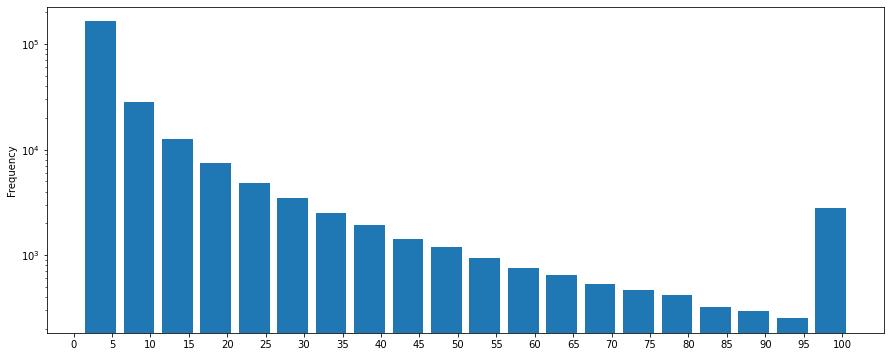

In [12]:
# Displaying item visit count distribution
events_distinct[events_distinct['event'] == 'view']\
.groupby(['itemid'])['visitorid']\
.nunique()\
.clip(0,101)\
.plot(kind='hist',
      bins= 20,
      rwidth=.8,
      log=True,
      xticks=np.arange(0, 102, step=5),
      figsize=(15,6))

### This figure shows that most items are being visited few times

In [13]:
# Displaying item visit count distribution
events_distinct[events_distinct['event'] == 'view']\
.groupby(['visitorid'])['itemid']\
.nunique()\
.quantile([0.5, 0.75, 0.9, 0.95, 0.99])

0.50   1.00
0.75   1.00
0.90   2.00
0.95   3.00
0.99   8.00
Name: itemid, dtype: float64

### This means that only 1% of our items being visited from more than 8 visitors in the last 4 months

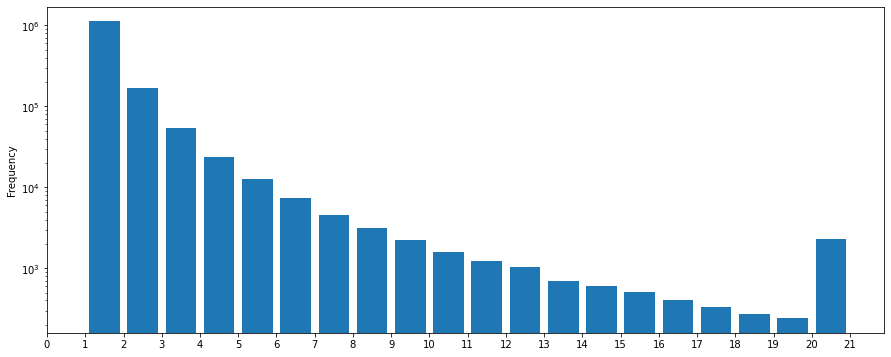

In [14]:
# Displaying customer visit count distribution
events_distinct[events_distinct['event'] == 'view']\
.groupby(['visitorid'])['itemid']\
.nunique()\
.clip(0,21)\
.plot(kind='hist',
      bins= 20,
      rwidth=.8,
      log=True,
      xticks=np.arange(0, 22, step=1),
      figsize=(15,6))

### This figure shows that most visitors visited very few items

In [15]:
# Event Counts
events_distinct.event.value_counts()

view           2664218
addtocart        68966
transaction      22457
Name: event, dtype: int64

In [16]:
# Number of unique values in each column
for col in events_distinct:
    print(col , events_distinct[col].nunique())

timestamp 2750455
visitorid 1407580
event 3
itemid 235061
transactionid 17672


In [17]:
# Checking Transactions without view or add to cart!
transaction_events= events_distinct[events_distinct['event']=='transaction'].reset_index(drop=True)
addtocart_events= events_distinct[events_distinct['event']=='addtocart'].reset_index(drop=True)
view_events= events_distinct[events_distinct['event']=='view'].reset_index(drop=True)

cart_transaction= transaction_events.merge(addtocart_events, how='inner', on=['visitorid', 'itemid'])
view_transaction= transaction_events.merge(view_events, how='inner', on=['visitorid', 'itemid'])
view_cart= addtocart_events.merge(view_events, how='inner', on=['visitorid', 'itemid'])

print('Transactions without addtocart event',
      transaction_events['visitorid'].nunique()-cart_transaction['visitorid'].nunique())
print('Transactions without view event',
      transaction_events['visitorid'].nunique()-view_transaction['visitorid'].nunique())
print('Addtocart without view event',
      addtocart_events['visitorid'].nunique()-view_cart['visitorid'].nunique())

Transactions without addtocart event 1226
Transactions without view event 696
Addtocart without view event 5564


In [18]:
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     uint32        
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), object(2), uint32(1)
memory usage: 696.1+ MB


In [19]:
# Checking for dublicates
duplicateRowsDF= item_properties[item_properties.duplicated(['itemid','property','value'], keep= False)].sort_values(by= ['itemid','property','value','timestamp'])
print("Duplicate Rows:", duplicateRowsDF.shape[0])
duplicateRowsDF.head(10)

Duplicate Rows: 8550788


,timestamp,itemid,property,value
2604501,2015-05-10 03:00:00,0,6,1152934 1238769
5387472,2015-05-17 03:00:00,0,6,1152934 1238769
3797200,2015-05-24 03:00:00,0,6,1152934 1238769
2405718,2015-05-31 03:00:00,0,6,1152934 1238769
3002067,2015-06-07 03:00:00,0,6,1152934 1238769
3598416,2015-06-14 03:00:00,0,6,1152934 1238769
5586256,2015-06-28 03:00:00,0,6,1152934 1238769
3399633,2015-07-05 03:00:00,0,6,1152934 1238769
3200850,2015-07-12 03:00:00,0,6,1152934 1238769
2803284,2015-07-19 03:00:00,0,6,1152934 1238769


In [20]:
# Removing Dublicates while keeping first value
item_properties_distinct= item_properties \
.sort_values('timestamp', ascending=True) \
.drop_duplicates(subset= ['itemid','property','value'], ignore_index= True)

### According to the data description if a property is constant over different snapshots, only one random record is left and all duplicates are removed.
### It would have been beter if we kept the first value not a random one.
## Assumptions...
#### 1- I will assume that the first occurance for each property value will be on the 3rd of May 2015.
#### 2- In case of value change, I will assume that this is the timestamp of the first occurance of the change.

In [21]:
# Applying our assumptions
item_properties_distinct['min_timestamp'] = item_properties_distinct.groupby(['itemid','property'])['timestamp'].transform('min')
item_properties_distinct['new_timestamp']= \
np.where((item_properties_distinct['min_timestamp'] != item_properties_distinct['timestamp'].min() - timedelta(days= 7)) & \
         (item_properties_distinct['min_timestamp'] == item_properties_distinct['timestamp']),
         item_properties_distinct['timestamp'].min() - timedelta(days= 7), None)
item_properties_distinct['new_timestamp'].fillna(item_properties_distinct['timestamp'],inplace= True)
item_properties_distinct.drop(columns=['min_timestamp','timestamp'],inplace= True)
item_properties_distinct.rename(columns={"new_timestamp": "timestamp"}, inplace=True, errors="raise")

In [22]:
item_properties_distinct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12778737 entries, 0 to 12778736
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   itemid     uint32        
 1   property   object        
 2   value      object        
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), object(2), uint32(1)
memory usage: 341.2+ MB


In [23]:
# Number of unique values in each column
for col in item_properties_distinct:
    print(col , item_properties_distinct[col].nunique())

itemid 417053
property 1104
value 1966868
timestamp 18


In [24]:
# Exploring item_properties
item_properties_distinct.groupby("property")\
.agg(record_count=('itemid', 'count'),
     distinct_item_count=('itemid', 'nunique'),
     distinct_value_count=('value', 'nunique'),
     distinct_values=('value', 'unique'))\
.sort_values(['distinct_item_count','record_count'], ascending=False).reset_index().head(100)

,property,record_count,distinct_item_count,distinct_value_count,distinct_values
0,790,758982,417053,33052,"[n32880.000, n24480.000, n157680.000, n11160.000, n15360.000, n876000.000, n8880.000, n46560.000, n105840.000, n0.000, n1800.000, n38484.000, n9960.000, n239400.000, n109200.000, n21840.000, n10680.000, n9600.000, n5280.000, n9720.000, n2640.000, n13680.000, n16680.000, n6600.000, n3840.000, n22920.000, n6840.000, n38040.000, n43176.000, n26400.000, n28200.000, n11040.000, n24720.000, n33360.000, n7440.000, n42120.000, n7560.000, n150840.000, n2712.000, n17796.000, n34440.000, n9360.000, n11..."
1,888,576145,417053,454723,"[47849 n706440.000, 150169 6872 614733 1071661 413916, 641688 1259019, 150169 727528 700105 1312425 697645 n9432.000, 1215939 n14820.000, 1327215 99163, 714481 173324 670844 639502 215341 910059 1192877, 236829 1305702 992862 951748 451156 n28.800 1135780 1284577 n187.200 1284577 n23040.000 628176 n12960.000 1284577 n144.000 1187104 1284577 n12.000 1175087 n12.000 1072114 1284577 1186729 769062 1284577 618514 980588 927741 376092 1284577 1141052 288796 1284577 814297 670753 n96.000, 686309 8..."
2,available,484054,417053,2,"[0, 1]"
3,categoryid,442432,417053,1242,"[769, 1441, 279, 1483, 991, 342, 1523, 646, 1007, 1511, 248, 1113, 508, 0, 1142, 656, 1119, 35, 64, 1277, 1163, 1403, 1408, 1432, 936, 976, 242, 847, 730, 1280, 1205, 1561, 1167, 844, 1552, 1653, 1674, 1503, 184, 558, 1120, 1639, 1634, 1666, 289, 1652, 209, 1192, 1221, 353, 1578, 173, 1477, 1188, 1074, 746, 360, 988, 1404, 1455, 928, 324, 217, 1680, 1393, 1378, 135, 1244, 1084, 1287, 350, 1196, 598, 1006, 228, 1279, 1255, 789, 1388, 1343, 686, 1228, 1, 450, 414, 130, 959, 429, 914, 1577, 858..."
4,283,428643,417053,333165,"[628374 827388 738621 628374 372324 703408 1182824 372324 892975 n48.000 1322464 237874 914255 727274 1273256 110652 1086985 1010780 145048 834282 827388 550504 780028 85384 303286 1094068 808508 976593 210086 1297039 197566, 1249027 212349 129268 726702, 125018 1137617 424149 358393 566381 n3600.000, 1312959 767591 435885 15301, 8496 639039 n48.000 229045, 550504 827388 802325 544147 737944 550504 827388 802325 342856 1242195 544147 737944 224903 639502 193250 150169 610517 1297729 1175087 ..."
5,364,420568,417053,420554,"[336749, 927727, 276288, 818640, 739673, 916201, 1196953, 247975, 1278017, 1283150, 799136, 1272930, 25293, 1200480, 158801, 725169, 579782, 955422, 279626, 1290601, 682521, 663527, 188756, 872794, 254918, 1096892, 1267696, 1190848, 1174683, 869411, 271083, 557613, 950874, 309449, 1322109, 51433, 354745, 659298, 148927, 399365, 552914, 1050680, 1326951, 1256345, 382940, 559068, 781995, 903112, 857971, 951127, 135303, 1161034, 1196086, 413372, 503199, 492826, 1183120, 1209928, 713959, 1013938..."
6,112,417053,417053,1,[679677]
7,159,417053,417053,1,[519769]
8,764,417053,417053,1,[1285872]
9,678,420884,417019,3832,"[113745, 695842 770783, 1262809, 894500, 1180441, 1100253, 98962, 1311256, 887323 115513, 1259877, 1167359, 697588, 85133 936288, 286484, 176870, 42652, 359853 444514, 456464, 1254637, 639778, 204918, 341411, 1055803, 959099 1142356, 699924, 888500, 886518, 1080067, 1031524, 732142 410093, 530902, 1297579, 646239, 961941, 817751, 227736, 486553 696454, 663619 537962, 865197, 699931, 953769, 1301021, 998537, 876041, 413631, 622363, 968068, 343546, 820477, 1150811 785275, 936918, 922011 840490..."


### We have 1104 different properties for our items. As we can see that most of the properties are null for the majority of our items. so i selected only the top 31 properties that most items have values in. Note that the feature number 31 have only 12% not null values.

In [25]:
# Selecting top 31 features
selected_properties= item_properties_distinct.property.value_counts().head(31).index.tolist()

item_properties_filtered= item_properties_distinct[
    item_properties_distinct['property']
    .isin(selected_properties)
].reset_index(drop=True)

# Pivoting table to switch from long to wide format
item_properties_wide= item_properties_filtered.pivot_table(index=["timestamp", "itemid"],
                                                           columns='property',
                                                           values='value',
                                                           aggfunc='first').reset_index()
item_properties_wide.columns.names= [None]

In [26]:
# Filling nulls with the constant values that did not change over different snapshots while applying our second assumption
item_properties_full= item_properties_wide.copy()

item_properties_full.update(
    item_properties_full
    .sort_values(by= ['timestamp'], ascending= True)
    .groupby(['itemid'])
    .ffill()
)

item_properties_full.update(
    item_properties_full
    .sort_values(by= ['timestamp'], ascending= True)
    .groupby(['itemid'])
    .bfill()
)

In [27]:
# Checking that some properties are not identical by printing differences count
print(item_properties_full[~(item_properties_full['698'] == item_properties_full['6']) &
                      ~(item_properties_full['698'].isna()) &
                      ~(item_properties_full['6'].isna())].shape[0])
print(item_properties_full[~(item_properties_full['839'] == item_properties_full['678']) &
                      ~(item_properties_full['839'].isna()) &
                      ~(item_properties_full['678'].isna())].shape[0])
print(item_properties_full[~(item_properties_full['202'] == item_properties_full['888']) &
                      ~(item_properties_full['202'].isna()) &
                      ~(item_properties_full['888'].isna())].shape[0])

117520
3813
388050


In [28]:
# Suspecting that property 790 is the price column
print('Number of non-numerical records',
      item_properties_full[item_properties_full['790'].str.contains('^n')== False]['790'].count())

Number of non-numerical records 0


In [29]:
# Adding from and to dates that item properties where constant over
item_properties_final= item_properties_full \
.sort_values('timestamp', ascending=True) \
.drop_duplicates(subset= ['itemid'] + selected_properties, ignore_index= True)

item_properties_final['to_timestamp'] = item_properties_final \
.sort_values(by=['timestamp'], ascending=True) \
.groupby(['itemid'])['timestamp'] \
.shift(-1) \
.fillna(item_properties_final['timestamp'].max() + timedelta(days= 7)) 

item_properties_final.rename(columns={"timestamp": "from_timestamp"}, inplace=True, errors="raise")

# Changing property 790 to price
item_properties_final['price'] = item_properties_final['790'].str.replace(r'n', '', regex=True)
item_properties_final['price']= pd.to_numeric(item_properties_final['price'], downcast='float')

# Arranging columns according to null count and importance
# Droping properties '112','159','764' as they are constant for all items
item_properties_final= item_properties_final[['from_timestamp','to_timestamp','itemid','categoryid','available','price',
                                              '888','364','283','678','917','202','776','6','839','227','698','689',
                                              '928','28','348','1036','713','810','19','400','243','434','38','46','960']]

In [30]:
# Saving new item properties dataframe
item_properties_final.to_csv('item_properties_final.csv',index=False)

In [31]:
# Reading new item properties dataframe and optimizing its memory
item_properties_final= pd.read_csv('item_properties_final.csv',low_memory=False)
item_properties_final['from_timestamp']= pd.to_datetime(item_properties_final['from_timestamp'])
item_properties_final['to_timestamp']= pd.to_datetime(item_properties_final['to_timestamp'])

for col in item_properties_final.select_dtypes(include=['int64']):
    item_properties_final[col]= pd.to_numeric(item_properties_final[col], downcast='unsigned')

for col in item_properties_final.select_dtypes(include=['float64']):
    item_properties_final[col]= pd.to_numeric(item_properties_final[col], downcast='float')

In [32]:
item_properties_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000266 entries, 0 to 1000265
Data columns (total 31 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   from_timestamp  1000266 non-null  datetime64[ns]
 1   to_timestamp    1000266 non-null  datetime64[ns]
 2   itemid          1000266 non-null  uint32        
 3   categoryid      1000266 non-null  uint16        
 4   available       1000266 non-null  uint8         
 5   price           1000266 non-null  float32       
 6   888             1000266 non-null  object        
 7   364             1000266 non-null  uint32        
 8   283             1000266 non-null  object        
 9   678             1000232 non-null  object        
 10  917             998842 non-null   object        
 11  202             992432 non-null   object        
 12  776             984818 non-null   float32       
 13  6               984729 non-null   object        
 14  839             96

In [33]:
item_properties_final.sort_values(by=['itemid','from_timestamp']).head(10)

,from_timestamp,to_timestamp,itemid,categoryid,available,price,888,364,283,678,917,202,776,6,839,227,698,689,928,28,348,1036,713,810,19,400,243,434,38,46,960
0,2015-05-03 03:00:00,2015-09-06 03:00:00,0,209,0,91200.00,478989,20716,66094 372274 478989,372274,478989,478989,318611.00,1152934 1238769,372274,1152934 1238769,1152934 1238769,NaN,NaN,NaN,NaN,1276750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
927598,2015-09-06 03:00:00,2015-09-20 03:00:00,0,209,0,91200.00,478989,20716,66094 372274 478989,372274,478989,478989,318611.00,66094,372274,1152934 1238769,1152934 1238769,NaN,NaN,NaN,NaN,1276750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
278039,2015-05-03 03:00:00,2015-05-17 03:00:00,1,1114,1,5760.00,172646,1299107,513325 1020281 1204938 172646 72261 30603 898004 140719 302848 1204938 190728 532620 572715 1128577 162103 1097148 288731 418473 150169 855390 836649 113294 435459 1103229 1019257 1272915 707081 13541 1161933 610340 804917,1204938,n372361069212.000,172646,379040.00,1020281,1204938,1020281 150169 1263524,1020281,150169 1263524,NaN,NaN,NaN,1154859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
432651,2015-05-17 03:00:00,2015-06-14 03:00:00,1,1114,0,5760.00,172646,1299107,513325 1020281 1204938 172646 72261 30603 898004 140719 302848 1204938 190728 532620 572715 1128577 162103 1097148 288731 418473 150169 855390 836649 113294 435459 1103229 1019257 1272915 707081 13541 1161933 610340 804917,1204938,n372361069212.000,172646,379040.00,1020281,1204938,1020281 150169 1263524,1020281,150169 1263524,NaN,NaN,NaN,1154859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
547839,2015-06-14 03:00:00,2015-06-28 03:00:00,1,1114,0,6240.00,172646,1299107,513325 1020281 1204938 172646 72261 30603 898004 140719 302848 1204938 190728 532620 572715 1128577 162103 1097148 288731 418473 150169 855390 836649 113294 435459 1103229 1019257 1272915 707081 13541 1161933 610340 804917,1204938,n372361069212.000,172646,379040.00,1020281,1204938,1020281 150169 1263524,1020281,150169 1263524,NaN,NaN,NaN,1154859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
579096,2015-06-28 03:00:00,2015-07-12 03:00:00,1,1114,0,6000.00,172646,1299107,513325 1020281 1204938 172646 72261 30603 898004 140719 302848 1204938 190728 532620 572715 1128577 162103 1097148 288731 418473 150169 855390 836649 113294 435459 1103229 1019257 1272915 707081 13541 1161933 610340 804917,1204938,n372361069212.000,172646,379040.00,1020281,1204938,1020281 150169 1263524,1020281,150169 1263524,NaN,NaN,NaN,1154859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
639608,2015-07-12 03:00:00,2015-09-06 03:00:00,1,1114,0,6120.00,172646,1299107,513325 1020281 1204938 172646 72261 30603 898004 140719 302848 1204938 190728 532620 572715 1128577 162103 1097148 288731 418473 150169 855390 836649 113294 435459 1103229 1019257 1272915 707081 13541 1161933 610340 804917,1204938,n372361069212.000,172646,379040.00,1020281,1204938,1020281 150169 1263524,1020281,150169 1263524,NaN,NaN,NaN,1154859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
927599,2015-09-06 03:00:00,2015-09-20 03:00:00,1,1114,0,6120.00,172646 1154859,1299107,513325 1020281 1204938 172646 72261 30603 898004 140719 302848 1204938 190728 532620 572715 1128577 162103 1097148 288731 418473 150169 855390 836649 113294 435459 1103229 1019257 1272915 707081 13541 1161933 610340 804917,1204938,n372361069212.000,172646,379040.00,1020281,1204938,1020281 150169 1263524,1020281,150169 1263524,NaN,NaN,NaN,1154859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
278038,2015-05-03 03:00:00,2015-09-20 03:00:00,2,1305,0,41040.00,648485 n6000.000 n72.000 n72.000 468140,1260440,822092 325894 504272 147366 343631 648485 n6000.000 n72.000 504272 147366 343631 648485 n6000.000 639502 n72.000 936990 949802 1113810 504272 653611 325894 1262898 796845 161652 150169 353870 1309799 1030323 608362 680618 1128577 636684 1081984 703408,147366 343631,648485 n6000.000 639502 n72.000,648485 n6000.000 n72.000,1005623.00,NaN,147366 343631,NaN,822092 325894 504272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan
278037,2015-05-03 03:00:00,2015-07-05 0

In [34]:
# Number of unique values in each column
l=[]
for col in item_properties_final:
    l.append((col,
              item_properties_final[col].count(),
              item_properties_final[~item_properties_final[col].isna()]['itemid'].nunique(),
              item_properties_final[col].nunique()))
pd.DataFrame(l,columns =['Column_name', 'Record_count', 'Item_count', 'Distinct_count'])\
.sort_values(by='Item_count', ascending=False)

,Column_name,Record_count,Item_count,Distinct_count
0,from_timestamp,1000266,417053,18
1,to_timestamp,1000266,417053,18
2,itemid,1000266,417053,417053
3,categoryid,1000266,417053,1242
4,available,1000266,417053,2
5,price,1000266,417053,33052
6,888,1000266,417053,454723
7,364,1000266,417053,420554
8,283,1000266,417053,333165
9,678,1000232,417019,3832


In [35]:
# Creating one dataframe with visitor events and item properties with its tree

# Joining with item_properties
events_full = events_distinct.merge(item_properties_final, how='left', on=['itemid'])
# Make sure that the transaction is between the start and end of the right item properties
events_full = events_full[(events_full['to_timestamp'].isna()== True) | 
                          (events_full['timestamp'].between(events_full['from_timestamp'],
                                                           events_full['to_timestamp'],
                                                           'left'))].reset_index(drop=True)
# Joining with category_tree
events_full= events_full.merge(category_tree, how='left', on=['categoryid'])

# Rearranging columns and sellecting non hashed ones
events_full= events_full[['timestamp','visitorid','event','itemid','categoryid',
                          'parentid','transactionid','available','price']]

# Adding date levels for aggregations
events_full['day']= events_full['timestamp'].dt.day_name().str.slice(0,3)
events_full['date']= events_full['timestamp'].dt.to_period('D')
events_full['weekno']= events_full['timestamp'].dt.strftime('%Y-w%U')
events_full['week']= events_full['timestamp'].dt.to_period('W-SAT')
events_full['month']= events_full['timestamp'].dt.to_period('M')
events_full['quarter']= events_full['timestamp'].dt.to_period('Q')
events_full['year']= events_full['timestamp'].dt.to_period('Y')

# Rearranging columns
events_full= events_full[['timestamp','date','weekno','week','month','quarter','year','day','visitorid',
                          'event','itemid','categoryid','parentid','transactionid','available','price']]

In [36]:
events_full.head()

,timestamp,date,weekno,week,month,quarter,year,day,visitorid,event,itemid,categoryid,parentid,transactionid,available,price
0,2015-06-02 05:02:12.117,2015-06-02,2015-w22,2015-05-31/2015-06-06,2015-06,2015Q2,2015,Tue,257597,view,355908,1173.00,805.00,nan,1.00,89280.00
1,2015-06-02 05:50:14.164,2015-06-02,2015-w22,2015-05-31/2015-06-06,2015-06,2015Q2,2015,Tue,992329,view,248676,1231.00,901.00,nan,1.00,19800.00
2,2015-06-02 05:13:19.827,2015-06-02,2015-w22,2015-05-31/2015-06-06,2015-06,2015Q2,2015,Tue,111016,view,318965,nan,nan,nan,nan,nan
3,2015-06-02 05:12:35.914,2015-06-02,2015-w22,2015-05-31/2015-06-06,2015-06,2015Q2,2015,Tue,483717,view,253185,914.00,226.00,nan,0.00,34740.00
4,2015-06-02 05:02:17.106,2015-06-02,2015-w22,2015-05-31/2015-06-06,2015-06,2015Q2,2015,Tue,951259,view,367447,1613.00,250.00,nan,1.00,443880.00


In [37]:
events_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2755641 entries, 0 to 2755640
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   date           period[D]     
 2   weekno         object        
 3   week           period[W-SAT] 
 4   month          period[M]     
 5   quarter        period[Q-DEC] 
 6   year           period[A-DEC] 
 7   day            object        
 8   visitorid      uint32        
 9   event          object        
 10  itemid         uint32        
 11  categoryid     float64       
 12  parentid       float64       
 13  transactionid  float64       
 14  available      float64       
 15  price          float32       
dtypes: datetime64[ns](1), float32(1), float64(4), object(3), period[A-DEC](1), period[D](1), period[M](1), period[Q-DEC](1), period[W-SAT](1), uint32(2)
memory usage: 325.9+ MB


In [38]:
# Number of unique values in each column
for col in events_full:
    print(col , events_full[col].nunique())

timestamp 2750455
date 139
weekno 20
week 20
month 5
quarter 2
year 1
day 7
visitorid 1407580
event 3
itemid 235061
categoryid 1148
parentid 286
transactionid 17672
available 2
price 20419


In [39]:
# Null count in each column
events_full.isna().sum()

timestamp              0
date                   0
weekno                 0
week                   0
month                  0
quarter                0
year                   0
day                    0
visitorid              0
event                  0
itemid                 0
categoryid        255576
parentid          255576
transactionid    2733184
available         255576
price             255576
dtype: int64

In [40]:
# Handeling nulls in some columns
events_full['categoryid']= events_full['categoryid'].fillna('NA')
events_full['parentid']= events_full['parentid'].fillna('NA')
events_full['available']= events_full['available'].fillna(1) # Assume they are all available
events_full['price']= events_full['price'].fillna(events_full.price.mean())

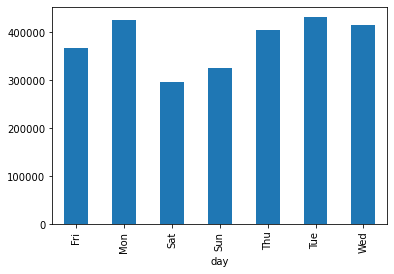

In [41]:
events_full[events_full['event'] == 'view']\
.groupby(['day'])['visitorid']\
.count()\
.plot(kind='bar')

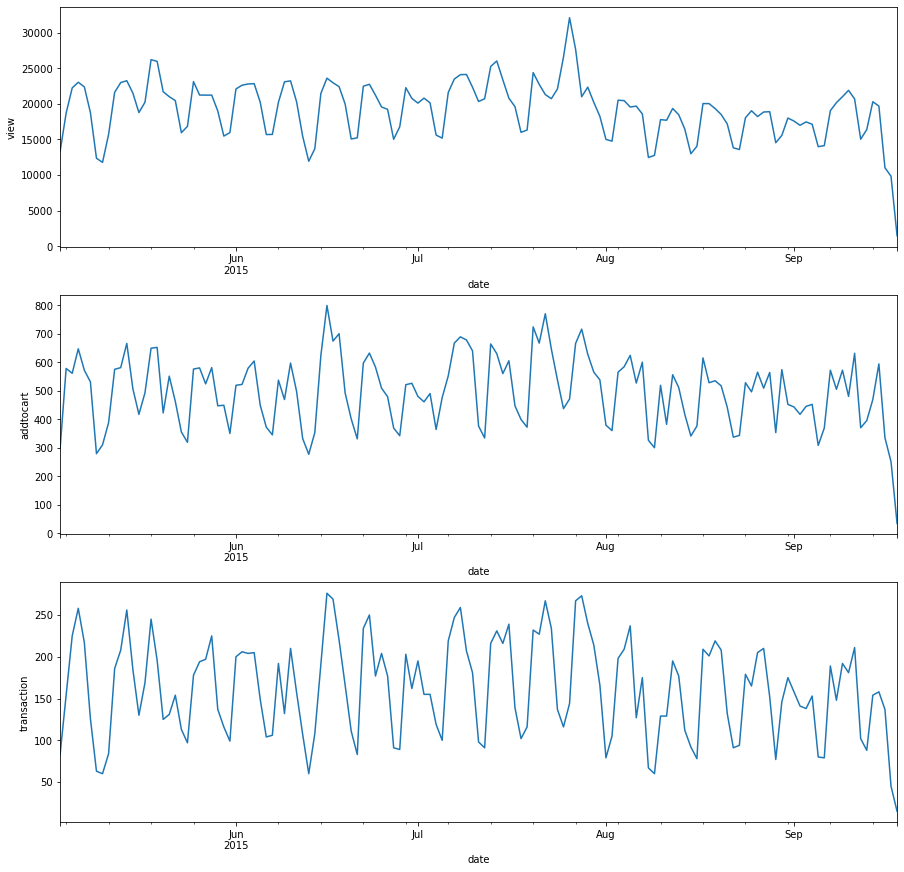

In [42]:
# events plot
figure, axes = plt.subplots(3, 1)
i=0
for val in events_full.event.unique().tolist():
    events_full[events_full['event'] == val]\
    .groupby(['date'])['visitorid']\
    .count()\
    .plot(kind='line',
          ax= axes[i],
          figsize=(15,15))
    plt.setp(axes[i], ylabel=val)
    i+=1

### Constant trend with weekly sesonality and low visitor numbers on Saterdays and Sundays

In [43]:
# Events summary to excel for dashboard
events_full\
.groupby(['date','weekno','week','month','quarter','year','day','event','available'])\
.agg(visitor_count  =('visitorid', 'nunique'),
     item_count     =('itemid', 'nunique'),
     category_count =('categoryid', 'nunique'),
     parent_count   =('parentid', 'nunique'),
     prices_sum     =('price', 'sum'))\
.reset_index()\
.to_excel("events_summary.xlsx",index=False)

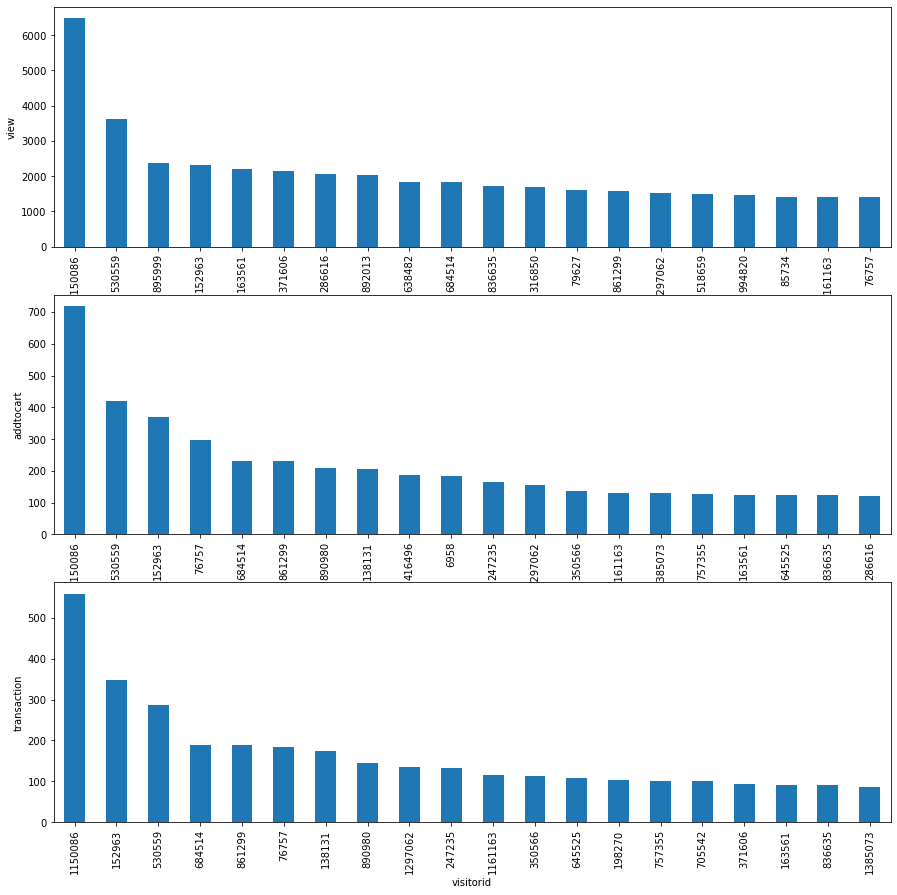

In [44]:
# top 20 visitors plot
figure, axes = plt.subplots(3, 1)
i=0
for val in events_full.event.unique().tolist():
    events_full[events_full['event'] == val]\
    .groupby(['visitorid'])['timestamp']\
    .count()\
    .nlargest(20)\
    .plot(kind='bar',
          ax= axes[i],
          figsize=(15,15))
    plt.setp(axes[i], ylabel=val)
    i+=1

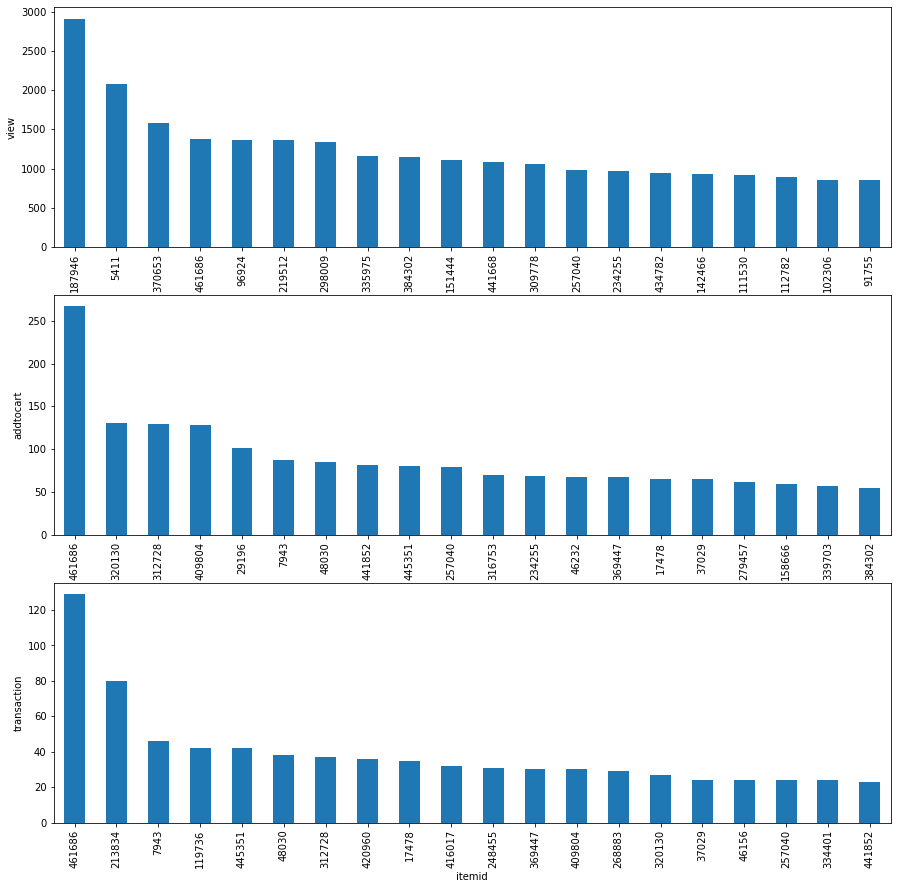

In [45]:
# top 20 items plot
figure, axes = plt.subplots(3, 1)
i=0
for val in events_full.event.unique().tolist():
    events_full[events_full['event'] == val]\
    .groupby(['itemid'])['visitorid']\
    .nunique()\
    .nlargest(20)\
    .plot(kind='bar',
          ax= axes[i],
          figsize=(15,15))
    plt.setp(axes[i], ylabel=val)
    i+=1

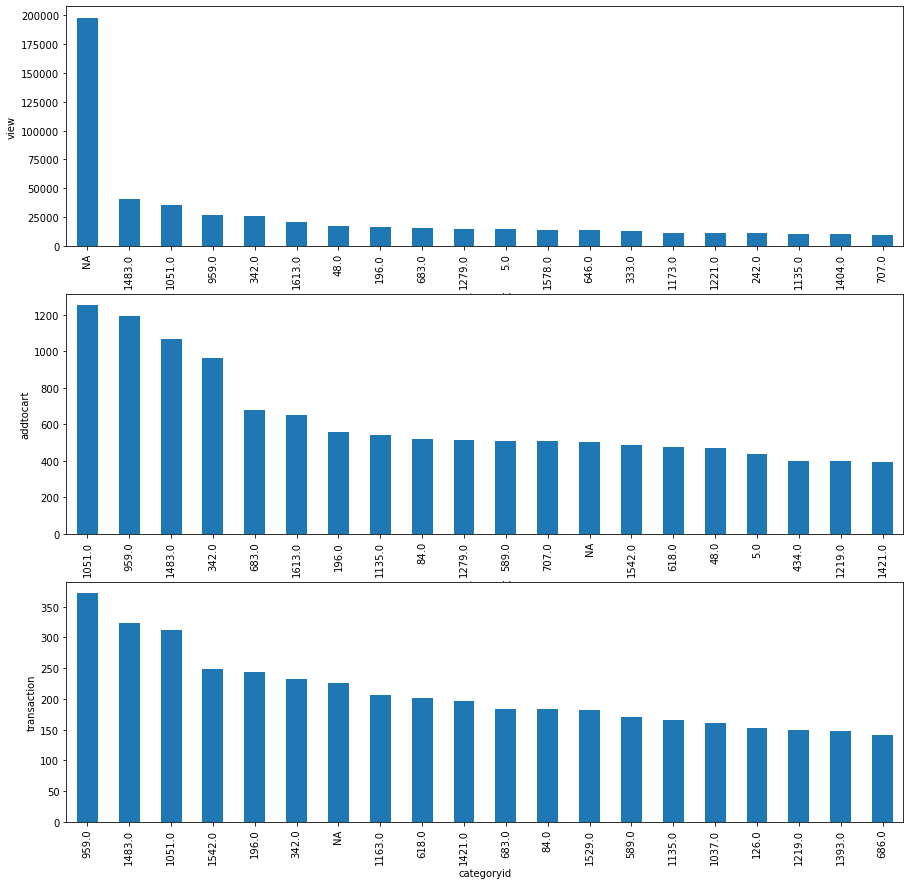

In [46]:
# top 20 categories plot
figure, axes = plt.subplots(3, 1)
i=0
for val in events_full.event.unique().tolist():
    events_full[events_full['event'] == val]\
    .groupby(['categoryid'])['visitorid']\
    .nunique()\
    .nlargest(20)\
    .plot(kind='bar',
          ax= axes[i],
          figsize=(15,15))
    plt.setp(axes[i], ylabel=val)
    i+=1

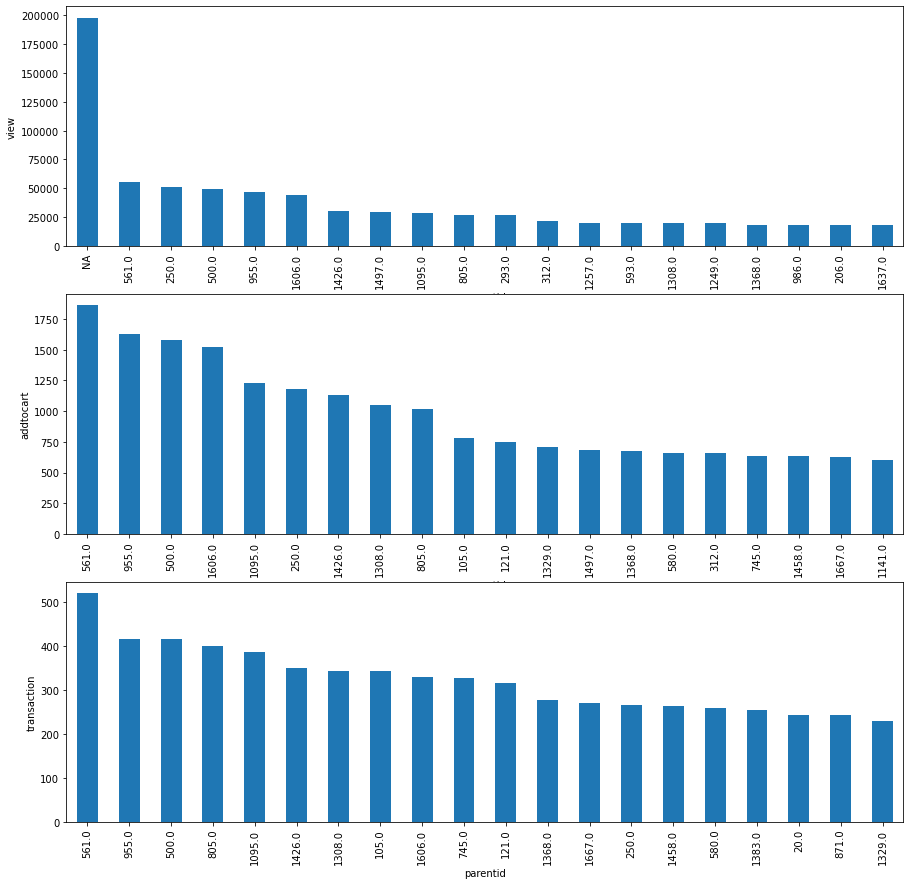

In [47]:
# top 20 parents plot
figure, axes = plt.subplots(3, 1)
i=0
for val in events_full.event.unique().tolist():
    events_full[events_full['event'] == val]\
    .groupby(['parentid'])['visitorid']\
    .nunique()\
    .nlargest(20)\
    .plot(kind='bar',
          ax= axes[i],
          figsize=(15,15))
    plt.setp(axes[i], ylabel=val)
    i+=1

In [48]:
# Item summary to excel for dashboard
events_full\
.groupby(['month','itemid','categoryid','parentid','event','available'])\
.agg(visit_count     =('timestamp', 'count'),
     visitor_count  =('visitorid', 'nunique'),
     avg_price      =('price', 'mean'))\
.reset_index()\
.to_excel("items_summary.xlsx",index=False)

## Model Building
### Market Basket Analysis Model is a technique that identifies the strength of association between a pair/group of products that are purchased together. In simpler words, it’s based on the concept that if a customer buys a product, they are more or less likely to buy another related product. Market Basket Analysis can be used as a recommendation engine.

In [49]:
basket_transaction = events_full[events_full['event'] == 'transaction']\
.groupby(['transactionid','itemid'])['itemid']\
.count().clip(0,1).unstack().reset_index().fillna(0)\
.set_index('transactionid')

In [50]:
## Needs more memory
# basket_addtocart = events_full[events_full['event'] == 'addtocart']\
# .groupby(['visitorid','itemid'])['itemid']\
# .count().clip(0,1).unstack().reset_index().fillna(0)\
# .set_index('visitorid')

In [51]:
## Needs massive memory
# basket_view = events_full[events_full['event'] == 'view']\
# .groupby(['visitorid','itemid'])['itemid']\
# .count().clip(0,1).unstack().reset_index().fillna(0)\
# .set_index('visitorid')

In [52]:
# Building the model
frq_items = apriori(basket_transaction, min_support = 0.0003, use_colnames = True, low_memory= False)

# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(32581),(461686),0.00,0.01,0.00,1.00,132.87,0.00,inf
9,(445351),(213834),0.00,0.01,0.00,0.87,166.48,0.00,7.46
4,(78268),(449391),0.00,0.00,0.00,0.86,1262.29,0.00,7.00
10,(218794),(461686),0.00,0.01,0.00,0.73,96.63,0.00,3.64
7,(171878),(461686),0.00,0.01,0.00,0.69,91.99,0.00,3.23
5,(449391),(78268),0.00,0.00,0.00,0.50,1262.29,0.00,2.00
8,(213834),(445351),0.01,0.00,0.00,0.42,166.48,0.00,1.73
0,(10572),(461686),0.00,0.01,0.00,0.42,55.95,0.00,1.71
12,(301721),(369158),0.00,0.00,0.00,0.39,361.71,0.00,1.63
13,(369158),(301721),0.00,0.00,0.00,0.37,361.71,0.00,1.58


### antecedents and consequents are items that are recommended to be bought with each other.

### This model needs huge memory for getting more recommendations
#### We can do different types of recommendations with this model.. 
#### People who viewed this product also viewed.
#### suggest what to buy with the item you are about to buy.